# Regressão logística

Vamos agora considerar o problema de *classificar* um conjunto de pessoas em adolescente ou adulto dependendo da altura.

### Leitura dos dados

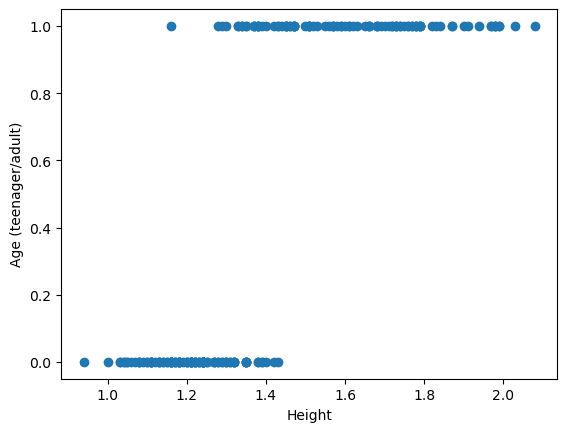

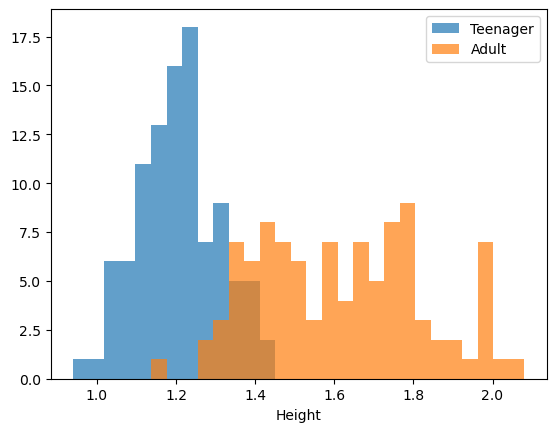

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

data = torch.from_numpy(np.loadtxt('../data/age_data_3.txt'))
inputs, targets = data.T

plt.scatter(inputs, targets)
plt.xlabel('Height')
plt.ylabel('Age (teenager/adult)')

bins = np.linspace(inputs.min(), inputs.max(), 30)
plt.figure()
plt.hist(inputs[targets==0], bins, alpha=0.7)
plt.hist(inputs[targets==1], bins, alpha=0.7)
plt.xlabel('Height')
plt.legend(('Teenager', 'Adult'))

### Definição do modelo

Nosso modelo é linear com uma função sigmóide para transformar a saída do modelo em probabilidades

Text(0, 0.5, 'P(Adult|Height)')

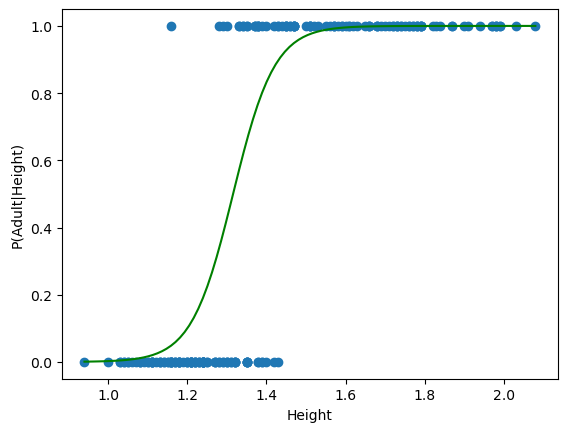

In [2]:
class Model:

    def __init__(self, a, b):

        # Parâmetros do modelo
        self.a = torch.tensor(a)
        self.b = torch.tensor(b)

    def __call__(self, x):
        y = self.a*x + self.b
        return  y
    
def sigmoid(x):

    y = 1/(1+torch.exp(-x))
    return y

model = Model(19., -25.)
scores = model(inputs)
# Probabilidade de cada pessoa ser adulta
probs = sigmoid(scores)

# Cálculo das probabilidades para todas as possíveis entradas x
inputsm = torch.linspace(inputs.min(), inputs.max(), 100)
scoresm = model(inputsm)
probsm = sigmoid(scoresm)

plt.scatter(inputs, targets)
plt.plot(inputsm, probsm, c='g')
plt.xlabel('Height')
plt.ylabel('P(Adult|Height)')

Ao rotularmos os dados como classe 0 e 1, estamos dizendo que temos 100% de certeza que esses dados estão nessas classes. Portanto, na ausência de qualquer outra informação sobre os dados, o melhor modelo que podemos desenvolver para o conjunto de treinamento é tal que:

* Quando o item é da classe 0, o modelo tem como resultado P(Adult|Height)=0.0
* Quando o item é da classe 1, o modelo tem como resultado P(Adult|Height)=1.0

In [3]:
#Acurácia do modelo
def acc(preds, targets):
    return torch.sum(preds==targets)/len(targets)

preds = probs>0.5
acc(preds, targets)

tensor(0.9000)

### Função de verossimilhança

In [4]:
def prob_of_target(probs, targets):
    '''Retorna as probabilidades da classe esperada'''
    return probs*targets + (1-probs)*(1-targets)

def likelihood(probs, targets):
    '''Função de verossimilhança.'''
    probs_correct = prob_of_target(probs, targets)
    return -torch.prod(probs_correct)

print(likelihood(probs, targets))

tensor(-2.2591e-20, dtype=torch.float64)


In [5]:
def nll(probs, targets):
    '''Negativo do logaritmo da função de verossimilhança'''
    probs_correct = prob_of_target(probs, targets)
    probs_log = torch.log(probs_correct)
    return -torch.sum(probs_log)

nll(probs, targets)

tensor(45.2367, dtype=torch.float64)

### Otimização do modelo

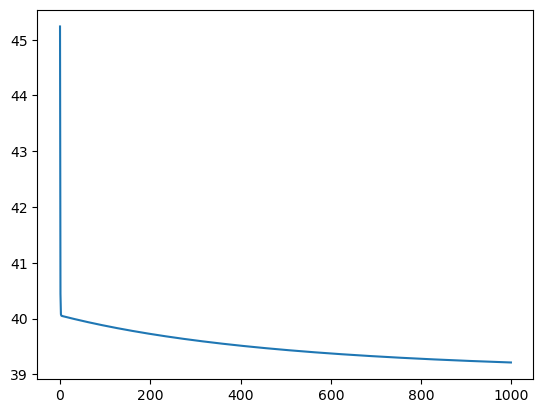

In [6]:
def step(model, inputs, targets, lr):

    # Apaga os gradientes
    model.a.grad = None
    model.b.grad = None
    scores = model(inputs)
    probs = sigmoid(scores)
    loss = nll(probs, targets)
    # Calcula os gradientes
    loss.backward()
    # Atualiza os gradientes
    with torch.no_grad():
        model.a -= lr*model.a.grad
        model.b -= lr*model.b.grad

    return loss.item()

model = Model(19., -25.)
model.a.requires_grad = True
model.b.requires_grad = True

num_epochs = 1000
lr = 0.03
losses = []
for epoch in range(0, num_epochs):
    loss = step(model, inputs, targets, lr)
    losses.append(loss)

plt.plot(losses)